In [1]:
import uproot as up
import numpy as np
import time
import iminuit
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
from iminuit.cost import UnbinnedNLL
from scipy.optimize import minimize
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3' 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from multiprocessing import Pool
import multiprocessing

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

sys.path.append('/software/pc24403/tfpcbpggsz/amp_ampgen')
from D0ToKSpipi2018 import *

Kspipi = PyD0ToKSpipi2018()
Kspipi.init()
print('INFO: Loading the amplitude model')




Num GPUs Available:  1
INFO: Loading the amplitude model
D0ToKSpipi2018 (Apr 30 2024) ==> Initialization !


# Mass shape

In [2]:
sys.path.append('/software/pc24403/tfpcbpggsz/func')

from tfmassshape import *
def preparePdf_data(Bu_M, varDict, mode='b2dk_LL'):
    '''
    Import constructed data sets and construct PDFs with RooFit functions.
    PDFs and data sets are saved together in a new RooWorkspace

    Args:
        configDict: a dictionary containing the values of PDF shape parameters
        year: which subset of data to fit, can be any single year of data taking,
              or 'Run1', 'Run2', 'All'.
    ''' 

    pdfList = {}

    print('--- Constructing signal pdfs...')
    varDict['DD_dk_Gauss_frac'] = 1 - varDict['DD_dk_Cruijff_frac']
    varDict['DD_dpi_Gauss_frac'] = 1- varDict['DD_dpi_Cruijff_frac']
    varDict['LL_dk_Gauss_frac'] = 1 - varDict['LL_dk_Cruijff_frac']
    varDict['LL_dpi_Gauss_frac'] = 1 - varDict['LL_dpi_Cruijff_frac']

    pdf_sig_Cruijff_DK_KsPiPi_DD  = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dk_DD'], varDict['sigma_dk_DD'], varDict['DD_dk_Cruijff_alpha_L'], varDict['DD_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DK_KsPiPi_DD    = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dk_DD'])

    pdf_sig_Cruijff_DPi_KsPiPi_DD = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_DD'], varDict['sigma_dpi_DD'], varDict['DD_dpi_Cruijff_alpha_L'], varDict['DD_dpi_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DPi_KsPiPi_DD   = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_DD'])
    pdf_sig_Cruijff_DK_KsPiPi_LL  = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dk_LL'], varDict['sigma_dk_LL'], varDict['LL_dk_Cruijff_alpha_L'], varDict['LL_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DK_KsPiPi_LL    = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dk_LL'])
    pdf_sig_Cruijff_DPi_KsPiPi_LL = lambda Bu_M: CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_LL'], varDict['sigma_dpi_LL'], varDict['LL_dpi_Cruijff_alpha_L'], varDict['LL_dpi_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DPi_KsPiPi_LL   = lambda Bu_M: Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_LL'])


    if mode == 'b2dk_LL':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(Bu_M, pdf_sig_Cruijff_DK_KsPiPi_LL) * varDict['LL_dk_Cruijff_frac'] +  norm_pdf(Bu_M, pdf_sig_Gauss_DK_KsPiPi_LL) * varDict['LL_dk_Gauss_frac'])
    elif mode == 'b2dpi_LL':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(Bu_M, pdf_sig_Cruijff_DPi_KsPiPi_LL) * varDict['LL_dpi_Cruijff_frac'] +   norm_pdf(Bu_M, pdf_sig_Gauss_DPi_KsPiPi_LL) *  varDict['LL_dpi_Gauss_frac'])
    elif mode == 'b2dk_DD':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(Bu_M, pdf_sig_Cruijff_DK_KsPiPi_DD) * varDict['DD_dk_Cruijff_frac'] +   norm_pdf(Bu_M, pdf_sig_Gauss_DK_KsPiPi_DD) *  varDict['DD_dk_Gauss_frac'])
    elif mode == 'b2dpi_DD':
        pdfList['sig'] = lambda Bu_M: (norm_pdf(Bu_M, pdf_sig_Cruijff_DPi_KsPiPi_DD) * varDict['DD_dpi_Cruijff_frac'] +  norm_pdf(Bu_M, pdf_sig_Gauss_DPi_KsPiPi_DD) * varDict['DD_dpi_Gauss_frac'])    
 

    print('--- Constructing misID pdfs...')
    pdf_misid_CB1_DK_KsPiPi_LL = lambda Bu_M: CBShape(Bu_M, varDict['LL_d2kspp_dpi_to_dk_misID_mean1'], varDict['LL_d2kspp_dpi_to_dk_misID_width1'], varDict['LL_d2kspp_dpi_to_dk_misID_alpha1'], varDict['LL_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB2_DK_KsPiPi_LL = lambda Bu_M: CBShape(Bu_M, varDict['LL_d2kspp_dpi_to_dk_misID_mean1'], varDict['LL_d2kspp_dpi_to_dk_misID_width2'], varDict['LL_d2kspp_dpi_to_dk_misID_alpha2'], varDict['LL_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB1_DK_KsPiPi_DD = lambda Bu_M: CBShape(Bu_M, varDict['DD_d2kspp_dpi_to_dk_misID_mean1'], varDict['DD_d2kspp_dpi_to_dk_misID_width1'], varDict['DD_d2kspp_dpi_to_dk_misID_alpha1'], varDict['DD_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB2_DK_KsPiPi_DD = lambda Bu_M: CBShape(Bu_M, varDict['DD_d2kspp_dpi_to_dk_misID_mean1'], varDict['DD_d2kspp_dpi_to_dk_misID_width2'], varDict['DD_d2kspp_dpi_to_dk_misID_alpha2'], varDict['DD_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB_DPi_KsPiPi_DD = lambda Bu_M: CBShape(Bu_M, varDict['DD_dk_to_dpi_misID_mean1'], varDict['DD_dk_to_dpi_misID_width1'], varDict['DD_dk_to_dpi_misID_alpha1'], varDict['DD_dk_to_dpi_misID_n1'])
    pdf_misid_CB_DPi_KsPiPi_LL = lambda Bu_M: CBShape(Bu_M, varDict['LL_dk_to_dpi_misID_mean1'], varDict['LL_dk_to_dpi_misID_width1'], varDict['LL_dk_to_dpi_misID_alpha1'], varDict['LL_dk_to_dpi_misID_n1'])
    if mode == 'b2dk_LL':
        pdfList['misid'] = lambda Bu_M: (norm_pdf(Bu_M, pdf_misid_CB1_DK_KsPiPi_LL) * varDict['LL_d2kspp_dpi_to_dk_misID_frac1'] + norm_pdf(Bu_M, pdf_misid_CB2_DK_KsPiPi_LL) * varDict['LL_d2kspp_dpi_to_dk_misID_frac2'])
    elif mode == 'b2dk_DD':
        pdfList['misid'] = lambda Bu_M: (norm_pdf(Bu_M, pdf_misid_CB1_DK_KsPiPi_DD) * varDict['DD_d2kspp_dpi_to_dk_misID_frac1'] + norm_pdf(Bu_M, pdf_misid_CB2_DK_KsPiPi_DD) * varDict['DD_d2kspp_dpi_to_dk_misID_frac2'])
    elif mode == 'b2dpi_LL':
        pdfList['misid'] = lambda Bu_M: norm_pdf(Bu_M, pdf_misid_CB_DPi_KsPiPi_LL) 
    elif mode == 'b2dpi_DD':
        pdfList['misid'] = lambda Bu_M: norm_pdf(Bu_M, pdf_misid_CB_DPi_KsPiPi_DD)

    print('--- Constructing low-mass pdfs...')
    varDict['low_sigma_k_DD'] = varDict['low_sigma_pi_DD']/varDict['low_sigma_pi_over_k_ratio']
    varDict['low_sigma_k_LL'] = varDict['low_sigma_pi_LL']/varDict['low_sigma_pi_over_k_ratio']
    varDict['low_sigma_gamma_dk'] = varDict['low_sigma_gamma']/varDict['low_sigma_pi_over_k_ratio_gamma']

    # B2Dsth (missing pi)
    pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_LL'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_DD'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bd_Dstarph_D0pi_dpi'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_LL'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bd_Dstarph_D0pi_dpi'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_DD'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'],  varDict['low_b_Bu_Dstar0h_D0pi0_dk'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_LL'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD  = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'],  varDict['low_b_Bu_Dstar0h_D0pi0_dk'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_DD'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL   = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],   varDict['low_b_Bd_Dstarph_D0pi_dk'],   varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_LL'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD   = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],   varDict['low_b_Bd_Dstarph_D0pi_dk'],   varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_DD'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    # DK misid
    pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'], varDict['low_b_Bu_Dstar0h_D0pi0_dk'], varDict['low_csi_pi'], varDict['m1pi_LL'], varDict['s1pi_LL'], varDict['m2pi_LL'], varDict['s2pi_LL'], varDict['m3pi_LL'], varDict['s3pi_LL'], varDict['m4pi_LL'], varDict['s4pi_LL'], varDict['f1pi_LL'], varDict['f2pi_LL'], varDict['f3pi_LL'])
    pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'], varDict['low_b_Bu_Dstar0h_D0pi0_dk'], varDict['low_csi_pi'], varDict['m1pi_DD'], varDict['s1pi_DD'], varDict['m2pi_DD'], varDict['s2pi_DD'], varDict['m3pi_DD'], varDict['s3pi_DD'], varDict['m4pi_DD'], varDict['s4pi_DD'], varDict['f1pi_DD'], varDict['f2pi_DD'], varDict['f3pi_DD'])
    pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],  varDict['low_b_Bd_Dstarph_D0pi_dk'],  varDict['low_csi_pi'], varDict['m1pi_LL'], varDict['s1pi_LL'], varDict['m2pi_LL'], varDict['s2pi_LL'], varDict['m3pi_LL'], varDict['s3pi_LL'], varDict['m4pi_LL'], varDict['s4pi_LL'], varDict['f1pi_LL'], varDict['f2pi_LL'], varDict['f3pi_LL'])
    pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],  varDict['low_b_Bd_Dstarph_D0pi_dk'],  varDict['low_csi_pi'], varDict['m1pi_DD'], varDict['s1pi_DD'], varDict['m2pi_DD'], varDict['s2pi_DD'], varDict['m3pi_DD'], varDict['s3pi_DD'], varDict['m4pi_DD'], varDict['s4pi_DD'], varDict['f1pi_DD'], varDict['f2pi_DD'], varDict['f3pi_DD'])
    # DPi misid
    pdf_low_misID_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_LL'], varDict['s1pi_pi_LL'], varDict['m2pi_pi_LL'], varDict['s2pi_pi_LL'], varDict['m3pi_pi_LL'], varDict['s3pi_pi_LL'], varDict['m4pi_pi_LL'], varDict['s4pi_pi_LL'], varDict['f1pi_pi_LL'], varDict['f2pi_pi_LL'], varDict['f3pi_pi_LL'])
    pdf_low_misID_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_DD'], varDict['s1pi_pi_DD'], varDict['m2pi_pi_DD'], varDict['s2pi_pi_DD'], varDict['m3pi_pi_DD'], varDict['s3pi_pi_DD'], varDict['m4pi_pi_DD'], varDict['s4pi_pi_DD'], varDict['f1pi_pi_DD'], varDict['f2pi_pi_DD'], varDict['f3pi_pi_DD'])
    pdf_low_misID_Bd_Dstarph_D0pi_DPi_KsPiPi_LL  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_LL'], varDict['s1pi_pi_LL'], varDict['m2pi_pi_LL'], varDict['s2pi_pi_LL'], varDict['m3pi_pi_LL'], varDict['s3pi_pi_LL'], varDict['m4pi_pi_LL'], varDict['s4pi_pi_LL'], varDict['f1pi_pi_LL'], varDict['f2pi_pi_LL'], varDict['f3pi_pi_LL'])
    pdf_low_misID_Bd_Dstarph_D0pi_DPi_KsPiPi_DD  = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_DD'], varDict['s1pi_pi_DD'], varDict['m2pi_pi_DD'], varDict['s2pi_pi_DD'], varDict['m3pi_pi_DD'], varDict['s3pi_pi_DD'], varDict['m4pi_pi_DD'], varDict['s4pi_pi_DD'], varDict['f1pi_pi_DD'], varDict['f2pi_pi_DD'], varDict['f3pi_pi_DD'])
    # B2Dsth (missing photon) 
    pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma'],    varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma'],    varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL  = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'],  varDict['low_b_Bu_Dstar0h_D0gamma_dk'],  varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma_dk'], varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD  = lambda Bu_M: HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'],  varDict['low_b_Bu_Dstar0h_D0gamma_dk'],  varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma_dk'], varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    # DK misid
    pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'], varDict['low_b_Bu_Dstar0h_D0gamma_dk'], varDict['low_csi_gamma'], varDict['m1ga'], varDict['s1ga'], varDict['m2ga'], varDict['s2ga'], varDict['m3ga'], varDict['s3ga'], varDict['m4ga'], varDict['s4ga'], varDict['f1ga'], varDict['f2ga'], varDict['f3ga'])
    pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'], varDict['low_b_Bu_Dstar0h_D0gamma_dk'], varDict['low_csi_gamma'], varDict['m1ga'], varDict['s1ga'], varDict['m2ga'], varDict['s2ga'], varDict['m3ga'], varDict['s3ga'], varDict['m4ga'], varDict['s4ga'], varDict['f1ga'], varDict['f2ga'], varDict['f3ga'])
    # DPi misid
    pdf_low_misID_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['m1ga_pi'], varDict['s1ga_pi'], varDict['m2ga_pi'], varDict['s2ga_pi'], varDict['m3ga_pi'], varDict['s3ga_pi'], varDict['m4ga_pi'], varDict['s4ga_pi'], varDict['f1ga_pi'], varDict['f2ga_pi'], varDict['f3ga_pi'])
    pdf_low_misID_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD = lambda Bu_M: HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['m1ga_pi'], varDict['s1ga_pi'], varDict['m2ga_pi'], varDict['s2ga_pi'], varDict['m3ga_pi'], varDict['s3ga_pi'], varDict['m4ga_pi'], varDict['s4ga_pi'], varDict['f1ga_pi'], varDict['f2ga_pi'], varDict['f3ga_pi'])

    # B2Dhpi
    # DPi
    pdf_B2Dpipi_1_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_I_B2Dpipi'],  varDict['low_b_I_B2Dpipi'],  varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_I_B2Dpipi'],  varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_1_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_I_B2Dpipi'],  varDict['low_b_I_B2Dpipi'],  varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_I_B2Dpipi'],  varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_2_DPi_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_II_B2Dpipi'], varDict['low_b_II_B2Dpipi'], varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_II_B2Dpipi'], varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_2_DPi_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_II_B2Dpipi'], varDict['low_b_II_B2Dpipi'], varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_II_B2Dpipi'], varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_DPi_KsPiPi_LL   = lambda Bu_M: norm_pdf(Bu_M, pdf_B2Dpipi_1_DPi_KsPiPi_LL) * varDict['low_frac_B2Dpipi'] + norm_pdf(Bu_M, pdf_B2Dpipi_2_DPi_KsPiPi_LL) * (1- varDict['low_frac_B2Dpipi'])
    pdf_B2Dpipi_DPi_KsPiPi_DD   = lambda Bu_M: norm_pdf(Bu_M, pdf_B2Dpipi_1_DPi_KsPiPi_DD) * varDict['low_frac_B2Dpipi'] + norm_pdf(Bu_M, pdf_B2Dpipi_2_DPi_KsPiPi_DD) * (1- varDict['low_frac_B2Dpipi'])
    # DK
    pdf_B2DKpi_1_DK_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_B2DKpi'], varDict['low_b_B2DKpi'], varDict['low_csi_B2DKpi'], varDict['low_global_shift'], varDict['low_sigma_B2DKpi'], varDict['low_ratio_B2DKpi'], varDict['low_f_B2DKpi'])
    pdf_B2DKpi_1_DK_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_B2DKpi'], varDict['low_b_B2DKpi'], varDict['low_csi_B2DKpi'], varDict['low_global_shift'], varDict['low_sigma_B2DKpi'], varDict['low_ratio_B2DKpi'], varDict['low_f_B2DKpi'])
    pdf_B2DKpi_2_DK_KsPiPi_LL = lambda Bu_M: Gaussian(Bu_M, varDict['low_mu_B2DKpi'], varDict['low_sigma_gaus_B2DKpi'])
    pdf_B2DKpi_2_DK_KsPiPi_DD = lambda Bu_M: Gaussian(Bu_M, varDict['low_mu_B2DKpi'], varDict['low_sigma_gaus_B2DKpi'])
    pdf_B2DKpi_DK_KsPiPi_LL   = lambda Bu_M: norm_pdf(Bu_M, pdf_B2DKpi_1_DK_KsPiPi_LL) * varDict['low_frac_B2DKpi'] + pdf_B2DKpi_2_DK_KsPiPi_LL(Bu_M) * (1- varDict['low_frac_B2DKpi'])
    pdf_B2DKpi_DK_KsPiPi_DD   = lambda Bu_M: norm_pdf(Bu_M, pdf_B2DKpi_1_DK_KsPiPi_DD) * varDict['low_frac_B2DKpi'] + pdf_B2DKpi_2_DK_KsPiPi_DD(Bu_M) * (1- varDict['low_frac_B2DKpi'])
    # DK misid
    pdf_low_misID_B2Dpipi_DK_KsPiPi_LL = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_B2Dpipi_misID'], varDict['low_b_B2Dpipi_misID'], varDict['low_csi_B2Dpipi'], varDict['low_m1_B2Dpipi_misID'], varDict['low_s1_B2Dpipi_misID'], varDict['low_m2_B2Dpipi_misID'], varDict['low_s2_B2Dpipi_misID'], varDict['low_m3_B2Dpipi_misID'], varDict['low_s3_B2Dpipi_misID'], varDict['low_m4_B2Dpipi_misID'], varDict['low_s4_B2Dpipi_misID'], varDict['low_f1_B2Dpipi_misID'], varDict['low_f2_B2Dpipi_misID'], varDict['low_f3_B2Dpipi_misID'])
    pdf_low_misID_B2Dpipi_DK_KsPiPi_DD = lambda Bu_M: HORNSdini_misID(Bu_M, varDict['low_a_B2Dpipi_misID'], varDict['low_b_B2Dpipi_misID'], varDict['low_csi_B2Dpipi'], varDict['low_m1_B2Dpipi_misID'], varDict['low_s1_B2Dpipi_misID'], varDict['low_m2_B2Dpipi_misID'], varDict['low_s2_B2Dpipi_misID'], varDict['low_m3_B2Dpipi_misID'], varDict['low_s3_B2Dpipi_misID'], varDict['low_m4_B2Dpipi_misID'], varDict['low_s4_B2Dpipi_misID'], varDict['low_f1_B2Dpipi_misID'], varDict['low_f2_B2Dpipi_misID'], varDict['low_f3_B2Dpipi_misID'])

    # Bs pdf
    pdf_low_Bs2DKPi_DK_KsPiPi_LL = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bs2DKpi'], varDict['low_b_Bs2DKpi'], varDict['low_csi_Bs2DKpi'], varDict['low_global_shift'], varDict['low_sigma_Bs2DKpi'], varDict['low_ratio_Bs2DKpi'], varDict['low_f_Bs2DKpi'])
    pdf_low_Bs2DKPi_DK_KsPiPi_DD = lambda Bu_M: HORNSdini(Bu_M, varDict['low_a_Bs2DKpi'], varDict['low_b_Bs2DKpi'], varDict['low_csi_Bs2DKpi'], varDict['low_global_shift'], varDict['low_sigma_Bs2DKpi'], varDict['low_ratio_Bs2DKpi'], varDict['low_f_Bs2DKpi'])

    if mode == 'b2dk_LL':
        pdfList['low_Bs2DKPi'] = lambda Bu_M: norm_pdf(Bu_M,pdf_low_Bs2DKPi_DK_KsPiPi_LL)
    elif mode == 'b2dk_DD':
        pdfList['low_Bs2DKPi'] = lambda Bu_M: norm_pdf(Bu_M, pdf_low_Bs2DKPi_DK_KsPiPi_DD)


    # Combine: with fractions
    if 'frac_low_Bu_Dstar0h_D0pi0_DPi' in varDict.keys():
        # Combine: DPi lowmass
        pdf_low_dpi_DPi_KsPiPi_LL = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DPi']*norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL) + varDict['frac_low_Bd_Dstarph_D0pi_DPi']* norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL) + varDict['frac_low_Bu_Dstar0h_D0gamma_DPi'] * norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL) + varDict['frac_low_B2Dpipi_DPi'] * norm_pdf(Bu_M, pdf_B2Dpipi_DPi_KsPiPi_LL)
        pdf_low_dpi_DPi_KsPiPi_DD = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DPi']*norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD) + varDict['frac_low_Bd_Dstarph_D0pi_DPi']* norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD) + varDict['frac_low_Bu_Dstar0h_D0gamma_DPi'] * norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD) + varDict['frac_low_B2Dpipi_DPi'] * norm_pdf(Bu_M, pdf_B2Dpipi_DPi_KsPiPi_DD)
        # Combine: DK lowmass
        pdf_low_dk_DK_KsPiPi_LL = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DK']*norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL) + varDict['frac_low_Bd_Dstarph_D0pi_DK']* norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL) + varDict['frac_low_Bu_Dstar0h_D0gamma_DK']* norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL) + varDict['frac_low_B2DKpi_DK']* norm_pdf(Bu_M, pdf_B2DKpi_DK_KsPiPi_LL)

        pdf_low_dk_DK_KsPiPi_DD = lambda Bu_M: varDict['frac_low_Bu_Dstar0h_D0pi0_DK']*norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD) + varDict['frac_low_Bd_Dstarph_D0pi_DK']* norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD) + varDict['frac_low_Bu_Dstar0h_D0gamma_DK'] * norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD) + varDict['frac_low_B2DKpi_DK']* norm_pdf(Bu_M, pdf_B2DKpi_DK_KsPiPi_DD)
        # Combine: DK misid
        pdf_low_misID_DK_KsPiPi_LL = lambda Bu_M: varDict['frac_low_misID_Bu_Dstar0h_D0pi0_DK']* norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL) + varDict['frac_low_misID_Bd_Dstarph_D0pi_DK']* norm_pdf(Bu_M, pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL) + varDict['frac_low_misID_Bu_Dstar0h_D0gamma_DK']* norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL) + varDict['frac_low_misID_B2Dpipi_DK']* norm_pdf(Bu_M, pdf_low_misID_B2Dpipi_DK_KsPiPi_LL)
        pdf_low_misID_DK_KsPiPi_DD = lambda Bu_M: varDict['frac_low_misID_Bu_Dstar0h_D0pi0_DK']* norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD) + varDict['frac_low_misID_Bd_Dstarph_D0pi_DK']* norm_pdf(Bu_M, pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD) + varDict['frac_low_misID_Bu_Dstar0h_D0gamma_DK']* norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD) + varDict['frac_low_misID_B2Dpipi_DK']* norm_pdf(Bu_M, pdf_low_misID_B2Dpipi_DK_KsPiPi_DD)
    else:
        # Combine: DPi lowmass
        pdf_low_dst2dpi_DPi_KsPiPi_LL = lambda Bu_M: norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL) * varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst'] + (1 - varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst']) *norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL)
        pdf_low_dst2dpi_DPi_KsPiPi_DD = lambda Bu_M: norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD) * varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst'] + (1 - varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst']) *norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD)
        pdf_low_dpi_dst_DPi_KsPiPi_LL = lambda Bu_M: norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL) * varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi'] + (1 - varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi']) * norm_pdf(Bu_M, pdf_low_dst2dpi_DPi_KsPiPi_LL)
        pdf_low_dpi_dst_DPi_KsPiPi_DD = lambda Bu_M: norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD) * varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi'] + (1 - varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi']) * norm_pdf(Bu_M, pdf_low_dst2dpi_DPi_KsPiPi_DD)
        pdf_low_dpi_DPi_KsPiPi_LL     = lambda Bu_M: norm_pdf(Bu_M, pdf_B2Dpipi_DPi_KsPiPi_LL) * varDict['low_dpi_ratio_b2drho_vs_b2dstpi'] + (1 - varDict['low_dpi_ratio_b2drho_vs_b2dstpi']) * norm_pdf(Bu_M, pdf_low_dpi_dst_DPi_KsPiPi_LL)
        pdf_low_dpi_DPi_KsPiPi_DD     = lambda Bu_M: norm_pdf(Bu_M, pdf_B2Dpipi_DPi_KsPiPi_DD) * varDict['low_dpi_ratio_b2drho_vs_b2dstpi'] + (1 - varDict['low_dpi_ratio_b2drho_vs_b2dstpi']) * norm_pdf(Bu_M, pdf_low_dpi_dst_DPi_KsPiPi_DD)
        # Combine: DK lowmass
        pdf_low_dst2dpi_DK_KsPiPi_LL = lambda Bu_M: norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL) * varDict['low_dk_ratio_Bd_dst_vs_Bu_dst'] + (1 - varDict['low_dk_ratio_Bd_dst_vs_Bu_dst']) * norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL) 
        pdf_low_dst2dpi_DK_KsPiPi_DD = lambda Bu_M: norm_pdf(Bu_M, pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD) * varDict['low_dk_ratio_Bd_dst_vs_Bu_dst'] + (1 - varDict['low_dk_ratio_Bd_dst_vs_Bu_dst']) * norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD)
        pdf_low_dk_dst_DK_KsPiPi_LL  = lambda Bu_M: norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL) * varDict['low_dk_ratio_dst2dgam_vs_dst2dk'] + (1 - varDict['low_dk_ratio_dst2dgam_vs_dst2dk']) * norm_pdf(Bu_M, pdf_low_dst2dpi_DK_KsPiPi_LL)
        pdf_low_dk_dst_DK_KsPiPi_DD  = lambda Bu_M: norm_pdf(Bu_M, pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD) * varDict['low_dk_ratio_dst2dgam_vs_dst2dk'] + (1 - varDict['low_dk_ratio_dst2dgam_vs_dst2dk']) * norm_pdf(Bu_M, pdf_low_dst2dpi_DK_KsPiPi_DD)
        pdf_low_dk_DK_KsPiPi_LL      = lambda Bu_M: norm_pdf(Bu_M, pdf_B2DKpi_DK_KsPiPi_LL) * varDict['low_dk_ratio_b2dkst_vs_b2dstk'] + (1- varDict['low_dk_ratio_b2dkst_vs_b2dstk']) *  norm_pdf(Bu_M, pdf_low_dk_dst_DK_KsPiPi_LL)
        pdf_low_dk_DK_KsPiPi_DD      = lambda Bu_M: norm_pdf(Bu_M, pdf_B2DKpi_DK_KsPiPi_DD) * varDict['low_dk_ratio_b2dkst_vs_b2dstk'] + (1- varDict['low_dk_ratio_b2dkst_vs_b2dstk']) *  norm_pdf(Bu_M, pdf_low_dk_dst_DK_KsPiPi_DD)
        # Combine: DK misid
        pdf_low_misID_dst2dpi_DK_KsPiPi_LL = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL) * varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst'] + (1 - varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst']) * norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL)
        pdf_low_misID_dst2dpi_DK_KsPiPi_DD = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD) * varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst'] + (1 - varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst']) * norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD)
        pdf_low_misID_dst_DK_KsPiPi_LL     = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL) * varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi'] + (1 - varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi']) * norm_pdf(Bu_M, pdf_low_misID_dst2dpi_DK_KsPiPi_LL)
        pdf_low_misID_dst_DK_KsPiPi_DD     = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD) * varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi'] + (1 - varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi']) * norm_pdf(Bu_M, pdf_low_misID_dst2dpi_DK_KsPiPi_DD)
        pdf_low_misID_DK_KsPiPi_LL         = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_B2Dpipi_DK_KsPiPi_LL) * varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi'] + (1 - varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi']) * norm_pdf(Bu_M, pdf_low_misID_dst_DK_KsPiPi_LL)
        pdf_low_misID_DK_KsPiPi_DD         = lambda Bu_M: norm_pdf(Bu_M, pdf_low_misID_B2Dpipi_DK_KsPiPi_DD) * varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi'] + (1 - varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi']) * norm_pdf(Bu_M, pdf_low_misID_dst_DK_KsPiPi_DD)

    if mode == 'b2dk_LL':
        pdfList['low'] = lambda Bu_M: (pdf_low_dk_DK_KsPiPi_LL(Bu_M))
        pdfList['low_misID'] = lambda Bu_M: (pdf_low_misID_DK_KsPiPi_LL(Bu_M))

    elif mode == 'b2dk_DD':
        pdfList['low'] = lambda Bu_M: pdf_low_dk_DK_KsPiPi_DD(Bu_M)
        pdfList['low_misID'] = lambda Bu_M: (pdf_low_misID_DK_KsPiPi_DD(Bu_M))

    elif mode == 'b2dpi_LL':
        pdfList['low'] = lambda Bu_M: (pdf_low_dpi_DPi_KsPiPi_LL(Bu_M))

    elif mode == 'b2dpi_DD':
        pdfList['low'] = lambda Bu_M: (pdf_low_dpi_DPi_KsPiPi_DD(Bu_M))


    # combinatorial
    print('--- Constructing comb pdfs...')
    pdf_comb_DK_KsPiPi_LL = lambda Bu_M: Exponential(Bu_M, varDict['comb_const_dk_d2kspp_LL'])
    pdf_comb_DK_KsPiPi_DD = lambda Bu_M: Exponential(Bu_M, varDict['comb_const_dk_d2kspp_DD'])
    pdf_comb_DPi_KsPiPi_LL = lambda Bu_M: Exponential(Bu_M, varDict['comb_const_dpi_d2kspp_LL'])
    pdf_comb_DPi_KsPiPi_DD = lambda Bu_M: Exponential(Bu_M, varDict['comb_const_dpi_d2kspp_DD'])
    if mode == 'b2dk_LL':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Bu_M, pdf_comb_DK_KsPiPi_LL)
    elif mode == 'b2dk_DD':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Bu_M, pdf_comb_DK_KsPiPi_DD)
    elif mode == 'b2dpi_LL':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Bu_M, pdf_comb_DPi_KsPiPi_LL)
    elif mode == 'b2dpi_DD':
        pdfList['comb'] = lambda Bu_M: norm_pdf(Bu_M, pdf_comb_DPi_KsPiPi_DD)


    print('--- INFO: Writing to file...')
    return pdfList

In [3]:
from importlib.machinery import SourceFileLoader

config_mass_shape_input = SourceFileLoader('config_mass_shape_input', '/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/config/lhcb/%s'%('config_cpfit_output_2.py')).load_module()
varDict_init = config_mass_shape_input.getconfig()


In [4]:
def get_mass(p1,p2):
    return ((p1[:,0]+p2[:,0])**2 - (p1[:,1]+p2[:,1])**2 - (p1[:,2]+p2[:,2])**2 - (p1[:,3]+p2[:,3])**2)


def get_p4(decay="b2dpi", cut='', index=2):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/new_frac_sw_pg/lhcb_toy_{decay}_{index}_CPrange.root:Bplus_DalitzEventList'
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x_test/{decay}_sig_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/new_frac_sw_pg/lhcb_toy_{decay}_{index}_CPrange.root:Bminus_DalitzEventList'
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x_test/{decay}_sig_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    
    array = tree.arrays(branch_names)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))



    return p1, p2, p3, p1bar, p2bar, p3bar

def load_int_amp(args):
    p1, p2, p3 = args

    return Kspipi.AMP(p1.tolist(), p2.tolist(), p3.tolist())

def getAmp(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    data = [(p1_np[i], p2_np[i], p3_np[i]) for i in range(len(p1_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitude.append(pool.map(load_int_amp, data))
    data_bar = [(p1bar_np[i], p3bar_np[i], p2bar_np[i]) for i in range(len(p1bar_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitudeBar.append(pool.map(load_int_amp, data_bar))
    
    end_time = time.time()
    print(f'Amplitude for {decay} loaded in {end_time-start_time} seconds')
    amplitude = np.array(amplitude)
    amplitudeBar = np.array(amplitudeBar)

    return amplitude, amplitudeBar
    
def get_p4_v2(decay="b2dpi", cut='', index=2, comp='sig'):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/new_frac_sw_pg/{decay}_{index}_CPrange.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/new_frac_sw_pg/{decay}_{index}_CPrange.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    charge = '(Bac_ID>0)'
    if cut == 'm':
        charge = '(Bac_ID<0)'
    
    array = tree.arrays(branch_names, charge)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))

    B_M = np.zeros(len(p1))
    if cut != 'int':
        
        B_M = np.asarray([array["B_M"]])


    return p1, p2, p3, p1bar, p2bar, p3bar, B_M


def getMass(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13

def getMass_v2(decay='b2dpi', cut='int', comp='sig'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp=comp)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13, B_M

In [15]:
sys.path.append('/software/pc24403/tfpcbpggsz/func')
sys.path.append('/software/pc24403/tfpcbpggsz/amp_ampgen')
#
mc_path = '/shared/scratch/pc24403/amp_ampgen'
#
amp_Data_dk_dd_p, ampbar_Data_dk_dd_p = getAmp('b2dk_DD', 'p')
amp_Data_dk_dd_m, ampbar_Data_dk_dd_m = getAmp('b2dk_DD', 'm')
#
#amp_Data_dpi_dd_p, ampbar_Data_dpi_dd_p = getAmp('b2dpi_DD', 'p')
#amp_Data_dpi_dd_m, ampbar_Data_dpi_dd_m = getAmp('b2dpi_DD', 'm')

Amplitude for b2dk_DD loaded in 6.192812919616699 seconds
Amplitude for b2dk_DD loaded in 5.816940069198608 seconds


In [5]:
pdfs_data = {}
s12_data = {}
s13_data = {}
Bu_M = {}
for decay in ['b2dk_DD', 'b2dpi_DD']:
    for charge in ['m', 'p']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Preparing pdfs for %s...'%new_decay)
        s12_data[new_decay], s13_data[new_decay], Bu_M[new_decay] = getMass_v2(decay, charge)
        pdfs_data[new_decay] = preparePdf_data(Bu_M[new_decay], varDict_init, decay)

    Bu_M[decay] = np.concatenate((Bu_M[decay+'_p'].flatten(), Bu_M[decay+'_m'].flatten()))
    pdfs_data[decay] = preparePdf_data(Bu_M[decay], varDict_init, decay)


--- INFO: Preparing pdfs for b2dk_DD_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dpi_DD_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dpi_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- Constructing signal pdfs...
--- Constructing m

In [35]:
@tf.function(reduce_retracing=True)
def norm_pdf(x, pdf):
    # Flatten the tensors for sorting purposes
    x_flat = tf.reshape(x, [-1])
    y_flat = tf.reshape(pdf(x), [-1])

    # Get the sorted indices and sort both x and y
    sorted_indices = tf.argsort(x_flat)
    sorted_x = tf.gather(x_flat, sorted_indices)
    sorted_y = tf.gather(y_flat, sorted_indices)

    # Perform integration using tfp.math.trapz along the second axis
    norm_const = tfp.math.trapz(sorted_y, sorted_x)

    a = tf.convert_to_tensor(pdf(x)/norm_const)
    return a

In [30]:
pdfs_data['b2dk_DD_p']['low_Bs2DKPi'](Bu_M['b2dk_DD_p'])

<tf.Tensor: shape=(1, 10415), dtype=float64, numpy=
array([[1.87226960e-05, 9.02444868e-06, 6.12059731e-09, ...,
        1.00908358e-02, 1.41095638e-02, 1.43630949e-02]])>

In [31]:
a = pdfs_data['b2dk_DD_p']['low_Bs2DKPi'](Bu_M['b2dk_DD_p'])

In [45]:
import numpy as np
def clip_log(x, _epsilon=1e-6):
    """clip log to allowed large value"""
    x_cut = tf.where(x > _epsilon, x, tf.ones_like(x) * _epsilon)
    b_t = tf.math.log(x_cut)

    delta_x = x - _epsilon
    b_f = (
       np.log(_epsilon) + delta_x / _epsilon - (delta_x / _epsilon) ** 2 / 2.0
    )
    print("$$$", b_t)
    return tf.where(x > _epsilon, b_t, b_f)

In [46]:
tf.reduce_sum(-2*clip_log(a))

$$$ tf.Tensor(
[[-10.88577408 -11.61557314 -13.81551056 ...  -4.59612762  -4.26090243
   -4.24309321]], shape=(1, 10415), dtype=float64)


<tf.Tensor: shape=(), dtype=float64, numpy=235357.30446625882>

(array([7.647e+03, 3.280e+02, 1.530e+02, 9.500e+01, 8.500e+01, 4.500e+01,
        3.500e+01, 3.100e+01, 2.700e+01, 2.200e+01, 2.200e+01, 2.000e+01,
        1.600e+01, 1.100e+01, 1.500e+01, 1.300e+01, 1.000e+01, 1.200e+01,
        7.000e+00, 8.000e+00, 4.000e+00, 5.000e+00, 1.300e+01, 8.000e+00,
        6.000e+00, 5.000e+00, 3.000e+00, 1.200e+01, 3.000e+00, 1.300e+01,
        4.000e+00, 8.000e+00, 6.000e+00, 7.000e+00, 1.200e+01, 4.000e+00,
        5.000e+00, 6.000e+00, 5.000e+00, 3.000e+00, 6.000e+00, 1.200e+01,
        4.000e+00, 6.000e+00, 7.000e+00, 2.000e+00, 4.000e+00, 6.000e+00,
        2.000e+00, 8.000e+00, 2.000e+00, 6.000e+00, 5.000e+00, 5.000e+00,
        7.000e+00, 7.000e+00, 4.000e+00, 5.000e+00, 1.000e+01, 4.000e+00,
        1.200e+01, 7.000e+00, 7.000e+00, 8.000e+00, 9.000e+00, 1.200e+01,
        1.000e+01, 7.000e+00, 7.000e+00, 7.000e+00, 6.000e+00, 1.000e+01,
        8.000e+00, 1.500e+01, 7.000e+00, 1.200e+01, 1.300e+01, 1.000e+01,
        1.200e+01, 1.100e+01, 1.800e+0

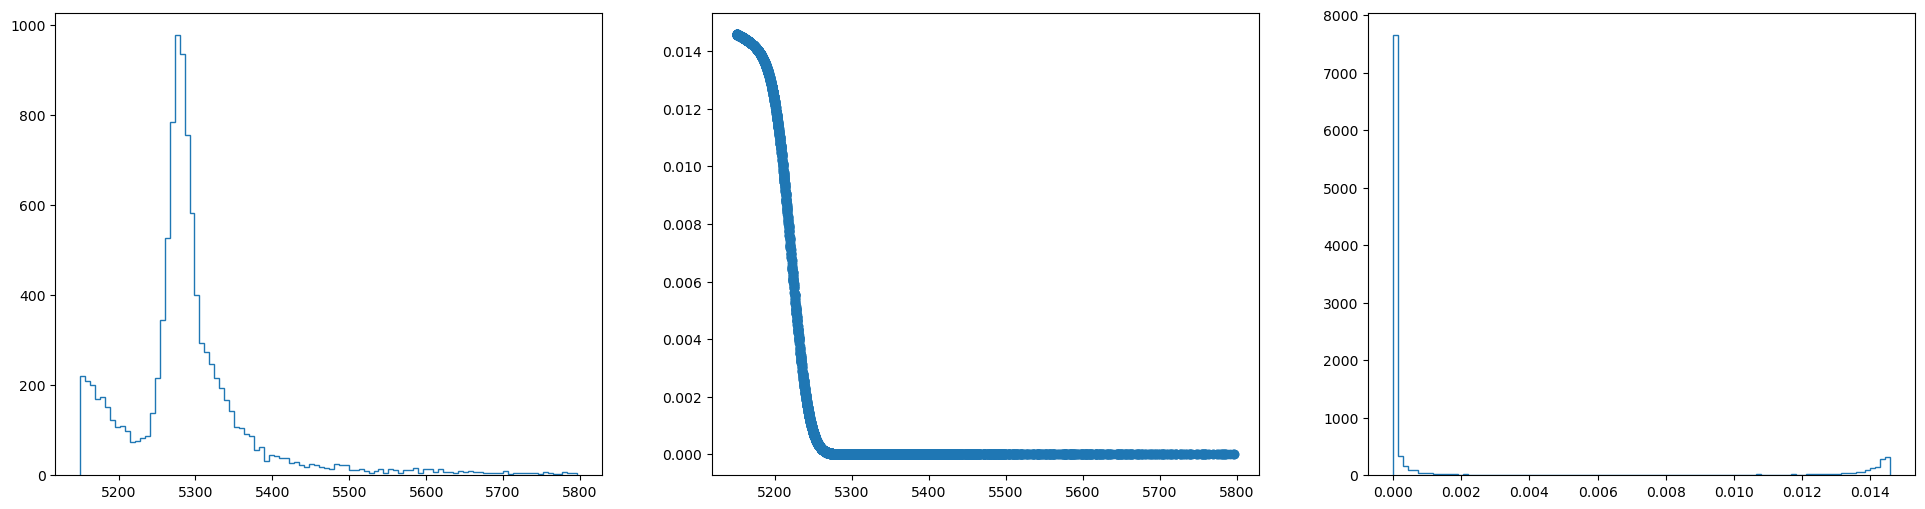

In [21]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8*3, 6))

ax0.hist(Bu_M['b2dk_DD_p'].flatten(), bins=100, histtype='step', label='sig')
ax1.plot(Bu_M['b2dk_DD_p'].flatten(), pdfs_data['b2dk_DD_p']['low_Bs2DKPi'](Bu_M['b2dk_DD_p'].flatten()), 'o', label='sig')
ax2.hist(pdfs_data['b2dk_DD_p']['low_Bs2DKPi'](Bu_M['b2dk_DD_p'].flatten()), bins=100, histtype='step', label='sig')

(array([ 20.,  18.,  15.,  14.,  24.,  25.,  18.,  17.,  13.,  14.,  19.,
         20.,  27.,  16.,  22.,  21.,  25.,  19.,  22.,  25.,  20.,  30.,
         24.,  27.,  24.,  30.,  32.,  19.,  33.,  31.,  31.,  45.,  45.,
         47.,  51.,  60.,  57.,  72.,  71.,  79., 114., 105., 125., 138.,
        172., 155., 178., 160., 173., 172., 196., 273., 332., 395., 505.,
        595., 582., 557., 523., 433., 357., 327., 218., 161., 135.,  96.,
         66.,  61.,  63.,  44.,  39.,  33.,  27.,  45.,  42.,  48.,  40.,
         45.,  48.,  42.,  58.,  52.,  46.,  60.,  53.,  58.,  59.,  74.,
         74.,  56.,  87.,  86.,  78.,  85.,  72.,  86.,  87.,  92.,  85.,
         99.]),
 array([0.00034891, 0.00038771, 0.0004265 , 0.0004653 , 0.0005041 ,
        0.00054289, 0.00058169, 0.00062048, 0.00065928, 0.00069807,
        0.00073687, 0.00077566, 0.00081446, 0.00085326, 0.00089205,
        0.00093085, 0.00096964, 0.00100844, 0.00104723, 0.00108603,
        0.00112482, 0.00116362, 0.00120242, 0.

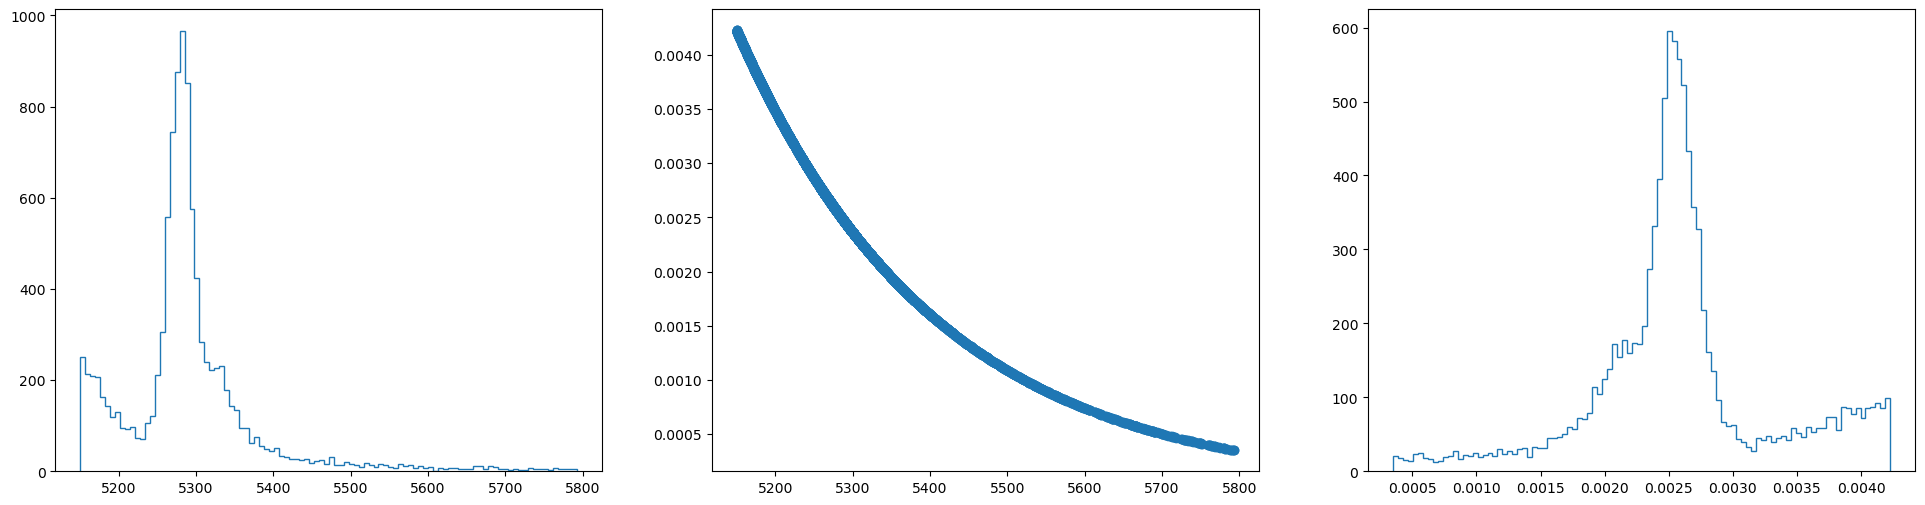

In [10]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8*3, 6))

ax0.hist(Bu_M['b2dk_DD_m'].flatten(), bins=100, histtype='step', label='sig')
ax1.plot(Bu_M['b2dk_DD_m'].flatten(), pdfs_data['b2dk_DD_m']['comb'](Bu_M['b2dk_DD_m'].flatten()), 'o', label='sig')
ax2.hist(pdfs_data['b2dk_DD_m']['comb'](Bu_M['b2dk_DD_m'].flatten()), bins=100, histtype='step', label='sig')

KeyboardInterrupt: 

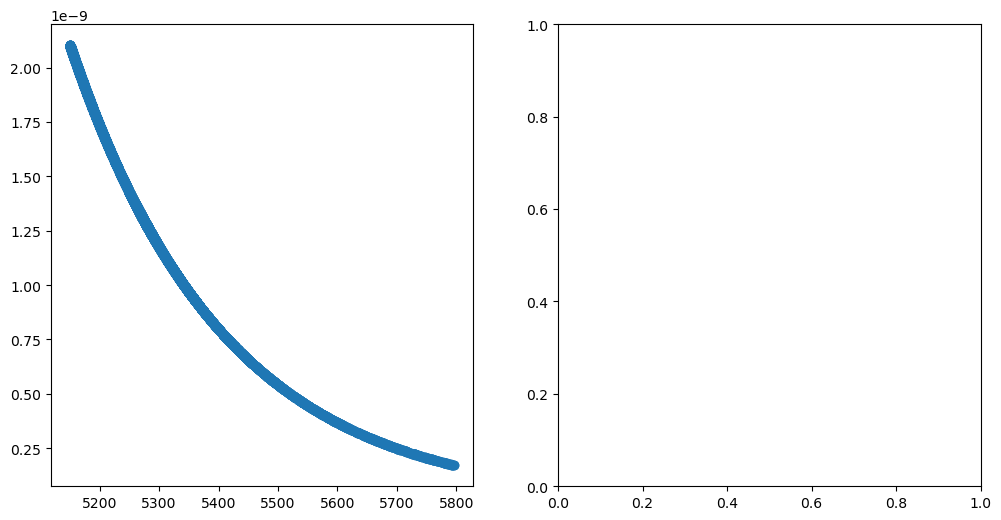

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

ax0.plot(Bu_M['b2dk_DD'], pdfs_data['b2dk_DD']['comb'](Bu_M['b2dk_DD']), 'o', label='sig')
ax1.hist(pdfs_data['b2dk_DD']['comb'](Bu_M['b2dk_DD']), bins=100, histtype='step', label='sig')

In [ ]:
from importlib.machinery import SourceFileLoader

config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/config/lhcb/%s'%('config_cpfit_output_2.py')).load_module()
varDict = config_mass_shape_output.getconfig()
x_exp = (varDict['n_sig_DK_KsPiPi_DD'], varDict['n_misid_DK_KsPiPi_DD'], varDict['n_comb_DK_KsPiPi_DD'], varDict['n_low_DK_KsPiPi_DD'], varDict['n_low_misID_DK_KsPiPi_DD'], varDict['n_low_Bs2DKPi_DK_KsPiPi_DD'])


In [ ]:
amp_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_amp.npy')
ampbar_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_ampbar.npy')
amp_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_amp.npy')
ampbar_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_ampbar.npy')

amp_dpi_dd_p = np.load(mc_path + '/Int_b2dpi_DD_p_amp.npy')
ampbar_dpi_dd_p = np.load(mc_path + '/Int_b2dpi_DD_p_ampbar.npy')
amp_dpi_dd_m = np.load(mc_path + '/Int_b2dpi_DD_m_amp.npy')
ampbar_dpi_dd_m = np.load(mc_path + '/Int_b2dpi_DD_m_ampbar.npy')


In [ ]:
sys.path.append('/software/pc24403/tfpcbpggsz/amp_ampgen')
sys.path.append('/software/pc24403/tfpcbpggsz/core')
from amp import *
from core import *

D0ToKSpipi2018 (Apr 30 2024) ==> Initialization !


In [ ]:
pdfs_data = {}
s12_data = {}
s13_data = {}
Bu_M = {}
index =2
for decay in ['b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Preparing pdfs for %s...'%new_decay)
        s12_data[new_decay], s13_data[new_decay], Bu_M[new_decay] = getMass_v2(decay, charge, index)
        pdfs_data[new_decay] = preparePdf_data(Bu_M[new_decay], varDict, decay)
        Bu_M[new_decay] = tf.constant(Bu_M[new_decay], tf.float32)

--- INFO: Preparing pdfs for b2dk_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_DD_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...


In [ ]:
pdfs_data = {}
s12_data = {}
s13_data = {}
Bu_M = {}
for decay in ['b2dk_DD', 'b2dpi_DD']:
    for charge in ['m', 'p']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Preparing pdfs for %s...'%new_decay)
        s12_data[new_decay], s13_data[new_decay], Bu_M[new_decay] = getMass_v2(decay, charge)
        pdfs_data[new_decay] = preparePdf_data(Bu_M[new_decay], varDict, decay)


print(tf.reduce_sum(tf.math.log(pdfs_data['b2dk_DD_p']['sig'](Bu_M['b2dk_DD_p']))))

--- INFO: Preparing pdfs for b2dk_DD_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dpi_DD_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dpi_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
tf.Tensor(-34015.923212994705, shape=(), dtype=float64)


In [ ]:
@tf.function
def prod_nll_dk_dd(x):

    decay = 'b2dk_DD'
    fracDD = 0.33
    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_p, ampbar_dpi_dd_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_m, ampbar_dpi_dd_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_m)**2)

    sig_prob_p = prod_totalAmplitudeSquared_XY(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, pdfs_data[decay+'_p']['sig'], pdfs_data[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = prod_totalAmplitudeSquared_XY(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, pdfs_data[decay+'_p']['sig'], pdfs_data[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = prod_totalAmplitudeSquared_DPi_XY(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, pdfs_data[decay+'_p']['misid'], pdfs_data[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = prod_totalAmplitudeSquared_DPi_XY(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, pdfs_data[decay+'_p']['misid'], pdfs_data[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = prod_comb(amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, pdfs_data[decay+'_p'], Bu_M[decay+'_p'], fracDD=fracDD)
    comb_prob_m = prod_comb(amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, pdfs_data[decay+'_m'], Bu_M[decay+'_m'], fracDD=fracDD)
    low_prob_p = prod_low(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, pdfs_data[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = prod_low(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, pdfs_data[decay+'_m'], Bu_M[decay+'_m'], type='low')
    low_misID_prob_p = prod_low(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, pdfs_data[decay+'_p'], Bu_M[decay+'_p'], type='low_misID')
    low_misID_prob_m = prod_low(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, pdfs_data[decay+'_m'], Bu_M[decay+'_m'], type='low_misID')
    low_Bs2DKPi_prob_p = prod_low(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, pdfs_data[decay+'_p'], Bu_M[decay+'_p'], type='low_Bs2DKPi')
    low_Bs2DKPi_prob_m = prod_low(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, pdfs_data[decay+'_m'], Bu_M[decay+'_m'], type='low_Bs2DKPi')


    total_yield = tf.cast((x[6] + x[7] + x[8] + x[9] + x[10] + x[11])/2, tf.float32)
    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 

    comb_normalisation_Bplus = tf.cast((normA_p + normAbar_p)*0.5*fracDD + (1-fracDD), tf.float32)
    comb_normalisation_Bminus = tf.cast((normA_m + normAbar_m)*0.5*fracDD + (1-fracDD), tf.float32)
    low_normalisation_Bplus = tf.cast(normAbar_p, tf.float32)
    low_normalisation_Bminus = tf.cast(normA_m, tf.float32)
    low_Bs2DKPi_normalisation_Bplus = tf.cast(normA_p, tf.float32)
    low_Bs2DKPi_normalisation_Bminus = tf.cast(normAbar_m, tf.float32)

    tf.print(total_yield)
    ll_data_p = tf.math.log(1/total_yield*((sig_prob_p/normalisation_Bplus) + (misid_prob_p/misid_normalisation_Bplus) + (comb_prob_p/comb_normalisation_Bplus) + (low_prob_p/low_normalisation_Bplus) + (low_misID_prob_p/low_normalisation_Bplus) + (low_Bs2DKPi_prob_p/low_Bs2DKPi_normalisation_Bplus)))
    ll_data_m = tf.math.log(1/total_yield*((sig_prob_m/normalisation_Bminus) + (misid_prob_m/misid_normalisation_Bminus) + (comb_prob_m/comb_normalisation_Bminus) + (low_prob_m/low_normalisation_Bminus) + (low_misID_prob_m/low_normalisation_Bminus) + (low_Bs2DKPi_prob_m/low_Bs2DKPi_normalisation_Bminus)))

    

    return (tf.reduce_sum( -2* ll_data_p) + tf.reduce_sum( -2*ll_data_m))

In [ ]:

def nll_dk_dd(x):
    x1 = x[:12]
    print(prod_nll_dk_dd(x1))
    return prod_nll_dk_dd(x1)

In [ ]:
xp = tf.Variable(0, tf.float32)
yp = tf.Variable(0, tf.float32)
xm = tf.Variable(0, tf.float32)
ym = tf.Variable(0, tf.float32)
xxi = tf.Variable(0, tf.float32)
yxi = tf.Variable(0, tf.float32)

#x = [xp, yp, xm, ym, xxi, yxi, varDict['n_sig_DK_KsPiPi_DD'], varDict['n_misid_DK_KsPiPi_DD'], varDict['n_comb_DK_KsPiPi_DD'], varDict['n_low_DK_KsPiPi_DD'], varDict['n_low_misID_DK_KsPiPi_DD'], varDict['n_low_Bs2DKPi_DK_KsPiPi_DD'], varDict['n_sig_DK_KsPiPi_LL'], varDict['n_misid_DK_KsPiPi_LL'], varDict['n_comb_DK_KsPiPi_LL'], varDict['n_low_DK_KsPiPi_LL'], varDict['n_low_misID_DK_KsPiPi_LL'], varDict['n_low_Bs2DKPi_DK_KsPiPi_LL'], varDict['n_misid_DPi_KsPiPi_DD'],  varDict['n_sig_DPi_KsPiPi_DD'], varDict['n_comb_DPi_KsPiPi_DD'], varDict['n_low_DPi_KsPiPi_DD'],  varDict['n_misid_DPi_KsPiPi_LL'], varDict['n_sig_DPi_KsPiPi_LL'], varDict['n_comb_DPi_KsPiPi_LL'], varDict['n_low_DPi_KsPiPi_LL']]
x = [-0.09, -0.011, 0.058, 0.07, -0.05, 0.007, varDict['n_sig_DK_KsPiPi_DD'], varDict['n_misid_DK_KsPiPi_DD'], varDict['n_comb_DK_KsPiPi_DD'], varDict['n_low_DK_KsPiPi_DD'], varDict['n_low_misID_DK_KsPiPi_DD'], varDict['n_low_Bs2DKPi_DK_KsPiPi_DD'], varDict['n_sig_DK_KsPiPi_LL'], varDict['n_misid_DK_KsPiPi_LL'], varDict['n_comb_DK_KsPiPi_LL'], varDict['n_low_DK_KsPiPi_LL'], varDict['n_low_misID_DK_KsPiPi_LL'], varDict['n_low_Bs2DKPi_DK_KsPiPi_LL'], varDict['n_misid_DPi_KsPiPi_DD'],  varDict['n_sig_DPi_KsPiPi_DD'], varDict['n_comb_DPi_KsPiPi_DD'], varDict['n_low_DPi_KsPiPi_DD'],  varDict['n_misid_DPi_KsPiPi_LL'], varDict['n_sig_DPi_KsPiPi_LL'], varDict['n_comb_DPi_KsPiPi_LL'], varDict['n_low_DPi_KsPiPi_LL']] 

m = iminuit.Minuit(nll_dk_dd, x)
m.fixed = [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
mg = m.scipy()

KeyboardInterrupt: 

In [ ]:
xp = tf.Variable(0, tf.float32)
yp = tf.Variable(0, tf.float32)
xm = tf.Variable(0, tf.float32)
ym = tf.Variable(0, tf.float32)
xxi = tf.Variable(0, tf.float32)
yxi = tf.Variable(0, tf.float32)

In [ ]:
x_phy = [xp, yp, xm, ym, xxi, yxi]

In [ ]:
x_yields = 

In [ ]:
x = tf.Variable(2.0, tf.float64)


In [ ]:
@tf.function
def f(x):
    return x * 2

In [ ]:
f(x)

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [ ]:
DeltadeltaD(amp_dk_dd_p[0], ampbar_dk_dd_p[0])


array([-0.04413212,  0.18449916,  1.28607347, ...,  0.15629232,
       -0.03127556,  0.26304428])

In [ ]:
%%time
@tf.function
def nll_extended_dk_dd(par):
    decay = 'b2dk_DD'
    x = tf.cast(Bu_M[decay], tf.float32)
    nsig = tf.cast(par[0], tf.float32)
    nmisid = tf.cast(varDict['n_misid_DK_KsPiPi_DD'], tf.float32)
    ncomb = tf.cast(par[1], tf.float32)
    nlow = tf.cast(par[2], tf.float32)

    frac_low_misID = tf.cast(varDict['n_low_misID_DK_KsPiPi_DD']/varDict['n_low_DK_KsPiPi_DD'], tf.float32)
    nlow_misID = tf.cast(varDict['n_low_misID_DK_KsPiPi_DD'], tf.float32)
    nlow_Bs2DKPi = tf.cast(varDict['n_low_Bs2DKPi_DK_KsPiPi_DD'], tf.float32)

    pdf =  pdfs_data[decay]['sig'](x)*nsig
    pdf2 = pdfs_data[decay]['misid'](x)*nmisid
    pdf3 = pdfs_data[decay]['comb'](x)*ncomb
    pdf4 = pdfs_data[decay]['low'](x)*nlow
    pdf5 = pdfs_data[decay]['low_misID'](x)*nlow_misID
    pdf6 = pdfs_data[decay]['low_Bs2DKPi'](x)*nlow_Bs2DKPi
    ntotal = (nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)

    npdf = pdf + pdf2 + pdf3 + pdf4 + pdf5 + pdf6

    nll = tf.reduce_sum(-2*tf.math.log(npdf)) + 2*ntotal
    return nll

@tf.function
def neg_like_and_gradient(parms):
    return tfp.math.value_and_gradient(nll_extended_dk_dd, parms)




CPU times: user 878 µs, sys: 967 µs, total: 1.85 ms
Wall time: 2 ms


In [ ]:
x_ini = [varDict_init['cp_range_n_sig_DK_KsPiPi_DD']*0.5, varDict_init['cp_range_n_comb_DK_KsPiPi_DD'], varDict_init['cp_range_n_low_DK_KsPiPi_DD']]


In [ ]:
m = Minuit(nll_extended_dk_dd, x_ini)
m.limits = [(0, varDict_init['cp_range_n_sig_DK_KsPiPi_DD']*3.5), (0, varDict_init['cp_range_n_comb_DK_KsPiPi_DD']*1.5), (10, varDict_init['cp_range_n_low_DK_KsPiPi_DD']*1.5)]
m.fixed = [False, True, True]
m.migrad()

Cause: Unable to locate the source code of <function nll_extended_dk_dd at 0x7f1cf8e17ce0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function nll_extended_dk_dd at 0x7f1cf8e17ce0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the fu

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.139e+05                 │              Nfcn = 43               │
│ EDM = 0.000977 (Goal: 0.0002)    │           time = 30.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  14.69e3  │  0.10e3   │            │            │    0    │ 33166.3 │       │
│ 1 │ x1   │  2.866e3  │  0.029e3  │            │            │    0    │ 4298.82 │  yes  │
│ 2 │ x2   │    520    │     5     │            │            │   10    │ 779.317 │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       x0       x1       x2 │
├────┼────────────────────────────┤
│ x0 │ 1.08e+04        0        0 │
│ x1 │        0        0        0 │
│ x2 │        0        0        0 │
└────┴────────────────────────────┘

In [ ]:
x_scan = np.linspace(2500, 3500, 10)

def nll_extended_dk_dd(par, x_int):
    decay = 'b2dk_DD'
    x = tf.cast(Bu_M[decay], tf.float32)
    nsig = tf.cast(varDict['n_sig_DK_KsPiPi_DD'], tf.float32)
    nmisid = tf.cast(varDict['n_misid_DK_KsPiPi_DD'], tf.float32)
    ncomb = tf.cast(x_int, tf.float32)
    nlow = tf.cast(par[2], tf.float32)

    frac_low_misID = tf.cast(varDict['n_low_misID_DK_KsPiPi_DD']/varDict['n_low_DK_KsPiPi_DD'], tf.float32)
    nlow_misID = tf.cast(varDict['n_low_misID_DK_KsPiPi_DD'], tf.float32)
    nlow_Bs2DKPi = tf.cast(varDict['n_low_Bs2DKPi_DK_KsPiPi_DD'], tf.float32)

    pdf =  pdfs_data[decay]['sig'](x)*nsig
    pdf2 = pdfs_data[decay]['misid'](x)*nmisid
    pdf3 = pdfs_data[decay]['comb'](x)*ncomb
    pdf4 = pdfs_data[decay]['low'](x)*nlow
    pdf5 = pdfs_data[decay]['low_misID'](x)*nlow_misID
    pdf6 = pdfs_data[decay]['low_Bs2DKPi'](x)*nlow_Bs2DKPi
    ntotal = (nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)

    npdf = pdf + pdf2 + pdf3 + pdf4 + pdf5 + pdf6

    nll = tf.reduce_sum(-2*tf.math.log(npdf)) + 2*ntotal
    return nll

In [ ]:
nll_scan = []
for i in range(len(x_scan)):
    nll_scan.append(nll_extended_dk_dd(x_ini, x_scan[i]))


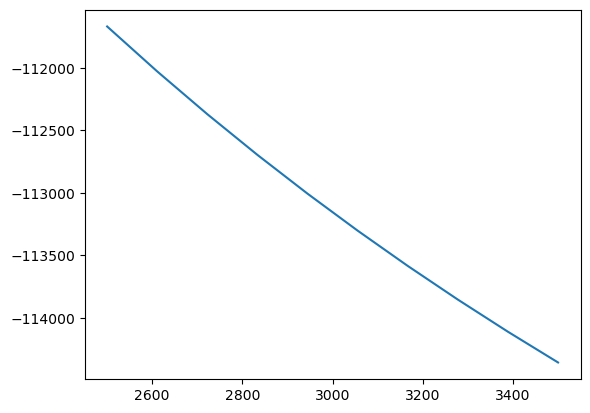

In [ ]:
plt.plot(x_scan, nll_scan)

In [ ]:
minimized_nsig = m.values[0]
minimized_nmisid = varDict_init['cp_range_n_misid_DK_KsPiPi_DD']#m.values[0]/varDict_init['pideff_DK_KsPiPi_k_to_k_DD'] * varDict_init['pideff_DK_KsPiPi_k_to_p_DD']
minimized_ncomb = m.values[1]
minimized_nlow = m.values[2]
minimized_nlow_misID = varDict_init['cp_range_n_low_misID_DK_KsPiPi_DD']
minimized_nlow_Bs2DKPi = varDict_init['cp_range_n_low_Bs2DKPi_DK_KsPiPi_DD']


In [ ]:
# using the same values as above
testval = tf.constant([1.0, 2.0, 3.0], shape=(3))
out = neg_like_and_gradient(parms=testval)
print("Function value: ", out[0])
print("Gradients: ", out[1])

Cause: Unable to locate the source code of <function neg_like_and_gradient at 0x7fb3d4707600>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function neg_like_and_gradient at 0x7fb3d4707600>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate 

In [ ]:
# optimization
optim_results = tfp.optimizer.bfgs_minimize(
    neg_like_and_gradient, testval, tolerance=1e-8)


In [ ]:
est_params = optim_results.position.numpy()
est_serr = np.sqrt(np.diagonal(optim_results.inverse_hessian_estimate.numpy()))
print("Estimated parameters: ", est_params)
print("Estimated standard errors: ", est_serr)

Estimated parameters:  [1. 2. 3.]
Estimated standard errors:  [1. 1. 1.]


In [ ]:
out = neg_like_and_gradient(est_params)
print("Function value: ", out[0])
print("Gradients: ", out[1])


Function value:  tf.Tensor(nan, shape=(), dtype=float32)
Gradients:  tf.Tensor([5.5163125e+03 3.2954745e+02 1.7352319e-01], shape=(3,), dtype=float32)


In [ ]:


n_data = {'b2dk_DD': len(Bu_M['b2dk_DD']), 'b2dpi_DD': len(Bu_M['b2dpi_DD'])}
print(n_data)
bounds = [(-n_data['b2dk_DD'], 1.2*n_data['b2dk_DD']), (-n_data['b2dk_DD'], 1.2*n_data['b2dk_DD']), (-n_data['b2dk_DD'], 1.2*n_data['b2dk_DD'])]
model = minimize(nll_extended_dk_dd, x_ini, method="L-BFGS-B", bounds=bounds)


{'b2dk_DD': 20904, 'b2dpi_DD': 156309}


In [ ]:
minimized_nsig = model.x[0]
minimized_nmisid = varDict_init['cp_range_n_misid_DK_KsPiPi_DD']#model.x[0]/varDict_init['pideff_DK_KsPiPi_k_to_k_DD'] * varDict_init['pideff_DK_KsPiPi_k_to_p_DD']
minimized_ncomb = model.x[1]
minimized_nlow = model.x[2]
minimized_nlow_misID = varDict_init['cp_range_n_low_misID_DK_KsPiPi_DD']
minimized_nlow_Bs2DKPi = varDict_init['cp_range_n_low_Bs2DKPi_DK_KsPiPi_DD']
model.success

True

In [ ]:
x_obs = [minimized_nsig, minimized_nmisid, minimized_ncomb, minimized_nlow, minimized_nlow_misID, minimized_nlow_Bs2DKPi]

In [ ]:
#Print the difference
print('nsig: %.2f'%minimized_nsig)
print('nmisid: %.2f'%minimized_nmisid)
print('ncomb: %.2f'%minimized_ncomb)
print('nlow: %.2f'%minimized_nlow)
print('nlow_misID: %.2f'%minimized_nlow_misID)
print('nlow_Bs2DKPi: %.2f'%minimized_nlow_Bs2DKPi)
print('ntotal: %.2f'%(minimized_nsig+minimized_nmisid+minimized_ncomb+minimized_nlow+minimized_nlow_misID+minimized_nlow_Bs2DKPi))
print('nsig: %.2f'%x_exp[0])
print('nmisid: %.2f'%x_exp[1])
print('ncomb: %.2f'%x_exp[2])
print('nlow: %.2f'%x_exp[3])
print('nlow_misID: %.2f'%x_exp[4])
print('nlow_Bs2DKPi: %.2f'%x_exp[5])
print('ntotal: %.2f'%(x_exp[0]+x_exp[1]+x_exp[2]+x_exp[3]+x_exp[4]+x_exp[5]))

nsig: 14214.13
nmisid: 4052.02
ncomb: 2865.88
nlow: 519.54
nlow_misID: 2476.18
nlow_Bs2DKPi: 257.78
ntotal: 24385.54
nsig: 10706.31
nmisid: 4019.96
ncomb: 2965.24
nlow: 434.39
nlow_misID: 2515.03
nlow_Bs2DKPi: 257.70
ntotal: 20898.64


In [ ]:
def plotOn(data=[], var=[], decay=decay,  nbins=100, ax=None, range=[5150, 5800]):


    density=False
    colors={'sig': 'blue', 'misid': 'yellowgreen', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}
    filled={'sig': False, 'misid': False, 'comb': True, 'low': True, 'low_misID': True, 'low_Bs2DKPi': True}
    bin_edges = np.linspace(range[0], range[1], nbins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_centers = tf.cast(bin_centers, tf.float32)
    # Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
    counts, _ = np.histogram(data[decay], bins=bin_edges, density=density)
    # Calculate the standard deviation for the error bars
    std_devs = np.sqrt(counts)
    ax.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet',  label='Toy Data')
    #for key in prob.keys():
    #ax.hist(var[decay], bins=100, histtype='step', weights=weights['sig']*data[decay].shape[1], label='sig')
    #ax.hist([var[decay], var[decay], var[decay], var[decay], var[decay], var[decay]], bins=100, histtype='step', stacked=True, weights=[weights[key]*var[decay].shape[1] for key in weights.keys()], label=[key for key in weights.keys()])
    keys=[ 'misid', 'sig'] 
    if decay.split('_')[0] == 'b2dk':
        keys=['misid', 'sig']
        colors={'sig': 'yellowgreen', 'misid': 'blue', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}
    weights = prob_extended(bin_centers, x_exp) 

    #ax.hist([var[decay] for key in keys], bins=100, histtype='step', stacked=False, weights=[(weights[key].flatten()) for key in keys], label=[key for key in keys], color=[colors[key] for key in keys], density=density)
    ax.plot(bin_centers, weights['total'](bin_centers)/sum(weights['total'](bin_centers))*len(data[decay]), color='red', label='Total ')
    ax.plot(bin_centers, weights['sig'](bin_centers)/sum(weights['total'](bin_centers))*len(data[decay]), color='blue', label='Signal')
    ax.plot(bin_centers, weights['misid'](bin_centers)/sum(weights['total'](bin_centers))*len(data[decay]), color='yellowgreen', label='MisID')
    ax.plot(bin_centers, weights['comb'](bin_centers)/sum(weights['total'](bin_centers))*len(data[decay]), color='violet', label='Combinatorial')
    ax.plot(bin_centers, weights['low'](bin_centers)/sum(weights['total'](bin_centers))*len(data[decay]), color='pink', label='Low')
    ax.plot(bin_centers, weights['low_misID'](bin_centers)/sum(weights['total'](bin_centers))*len(data[decay]), color='silver', label='Low MisID')
    ax.plot(bin_centers, weights['low_Bs2DKPi'](bin_centers)/sum(weights['total'](bin_centers))*len(data[decay]), color='green', label='Low Bs2DKPi')
    #ax.hist(var[decay], weights=sum_weights.flatten()*scale_factor, color='red', label='Total',bins=100, histtype='step', density=density)
    ax.legend()

    ax.set_xlabel('$M(B^{\pm})$')

<>:35: SyntaxWarning: invalid escape sequence '\p'
<>:35: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_162913/2769646000.py:35: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$M(B^{\pm})$')


In [ ]:
%%time


def prob_extended(Bu_M, par):
    decay = 'b2dk_DD'
    x = tf.cast(Bu_M, tf.float32)
    nsig = tf.cast(par[0], tf.float32)
    nmisid = tf.cast(par[1], tf.float32)
    ncomb = tf.cast(par[2], tf.float32)
    nlow = tf.cast(par[3], tf.float32)
    nlow_misID = tf.cast(par[4], tf.float32)
    nlow_Bs2DKPi = tf.cast(par[5], tf.float32)

    pdf = pdfs_data['b2dk_DD']['sig']
    pdf2 = pdfs_data['b2dk_DD']['misid']
    pdf3 = pdfs_data['b2dk_DD']['comb']
    pdf4 = pdfs_data['b2dk_DD']['low']
    pdf5 = pdfs_data['b2dk_DD']['low_misID']
    pdf6 = pdfs_data['b2dk_DD']['low_Bs2DKPi']
    ntotal = (nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)

    npdf = nsig*pdf(x) + nmisid*pdf2(x) + ncomb*pdf3(x) + nlow*pdf4(x) + nlow_misID*pdf5(x) + nlow_Bs2DKPi*pdf6(x)

    prob={}
    prob['total'] = lambda x:  (nsig*pdf(x) + nmisid*pdf2(x) + ncomb*pdf3(x) + nlow*pdf4(x) + nlow_misID*pdf5(x) + nlow_Bs2DKPi*pdf6(x))/ntotal
    prob['sig'] = lambda x: nsig*pdf(x)/ntotal
    prob['misid'] = lambda x: nmisid*pdf2(x)/ntotal
    prob['comb'] = lambda x: ncomb*pdf3(x)/ntotal
    prob['low'] = lambda x: nlow*pdf4(x)/ntotal
    prob['low_misID'] = lambda x:nlow_misID*pdf5(x)/ntotal
    prob['low_Bs2DKPi'] = lambda x:nlow_Bs2DKPi*pdf6(x)/ntotal

    
    return prob


CPU times: user 59 µs, sys: 14 µs, total: 73 µs
Wall time: 114 µs


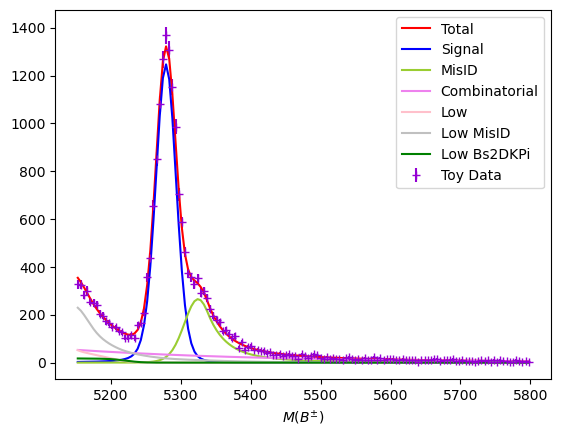

In [ ]:
fig, ax = plt.subplots()
plotOn(data=Bu_M, var=[], decay='b2dk_DD',  ax=ax, nbins=144)



# Only fit on DPi

In [ ]:
def nll_extended_dpi_dd(par):
    decay = 'b2dpi_DD'
    x= Bu_M[decay]
    nsig = par[0]
    nmisid = varDict_init['cp_range_n_sig_DK_KsPiPi_DD']/(varDict_init['pideff_DK_KsPiPi_k_to_k_DD']) * varDict_init['pideff_DK_KsPiPi_k_to_p_DD']
    ncomb = par[1]
    nlow = par[2]

    pdf = lambda x: pdfs_data[decay]['sig'](x)*nsig
    pdf2 = lambda x: pdfs_data[decay]['misid'](x)*nmisid
    pdf3 = lambda x: pdfs_data[decay]['comb'](x)*ncomb
    pdf4 = lambda x: pdfs_data[decay]['low'](x)*nlow

    ntotal = (nsig + nmisid + ncomb + nlow )

    npdf = pdf(x) + pdf2(x) + pdf3(x) + pdf4(x)

    nll = tf.reduce_sum(- 2 * np.log(npdf)) + 2 * ntotal
    
    return nll 

In [ ]:
x_ini = (varDict_init['n_sig_DPi_KsPiPi_DD'], varDict_init['n_comb_DPi_KsPiPi_DD'], varDict_init['n_low_DPi_KsPiPi_DD'])
bounds = [(-x_ini[0], 5*x_ini[0]), (-x_ini[1], 5*x_ini[1]), (-x_ini[2], 5*x_ini[2])]
model = minimize(nll_extended_dpi_dd, x_ini, method="L-BFGS-B", bounds=bounds)

/tmp/ipykernel_120626/804192898.py:18: RuntimeWarning: invalid value encountered in log
  nll = tf.reduce_sum(- 2 * np.log(npdf)) + 2 * ntotal


In [ ]:
minimized_nsig = model.x[0]
minimized_nmisid = varDict_init['cp_range_n_misid_DPi_KsPiPi_DD']
minimized_ncomb = model.x[1]
minimized_nlow = model.x[2]


In [ ]:
x_exp = (varDict['n_sig_DPi_KsPiPi_DD'], varDict['n_misid_DPi_KsPiPi_DD'], varDict['n_comb_DPi_KsPiPi_DD'], varDict['n_low_DPi_KsPiPi_DD'])


In [ ]:
x_obs = [minimized_nsig, minimized_nmisid, minimized_ncomb, minimized_nlow]

In [ ]:
#Print the difference
print('nsig: %.2f'%minimized_nsig)
print('nmisid: %.2f'%minimized_nmisid)
print('ncomb: %.2f'%minimized_ncomb)
print('nlow: %.2f'%minimized_nlow)
print('ntotal: %.2f'%(minimized_nsig+minimized_nmisid+minimized_ncomb+minimized_nlow))
print('nsig: %.2f'%x_exp[0])
print('nmisid: %.2f'%x_exp[1])
print('ncomb: %.2f'%x_exp[2])
print('nlow: %.2f'%x_exp[3])
print('ntotal: %.2f'%(x_exp[0]+x_exp[1]+x_exp[2]+x_exp[3]))

nsig: 137475.36
nmisid: 1418.44
ncomb: 7506.78
nlow: 9427.72
ntotal: 155828.29
nsig: 138028.07
nmisid: 1613.96
ncomb: 7379.43
nlow: 9294.26
ntotal: 156315.71


In [ ]:
%%time


def prob_extended_dpi(Bu_M, par):
    decay = 'b2dpi_DD'
    x = Bu_M
    nsig = par[0]
    nmisid = par[1]
    ncomb = par[2]
    nlow = par[3]


    pdf = pdfs_data[decay]['sig']
    pdf2 = pdfs_data[decay]['misid']
    pdf3 = pdfs_data[decay]['comb']
    pdf4 = pdfs_data[decay]['low']
    ntotal = 1#(nsig + nmisid + ncomb + nlow)

    npdf = nsig*pdf(x) + nmisid*pdf2(x) + ncomb*pdf3(x) + nlow*pdf4(x)

    prob={}
    prob['total'] = lambda x:  (nsig*pdf(x) + nmisid*pdf2(x) + ncomb*pdf3(x) + nlow*pdf4(x) )/ntotal
    prob['sig'] = lambda x: nsig*pdf(x)/ntotal
    prob['misid'] = lambda x: nmisid*pdf2(x)/ntotal
    prob['comb'] = lambda x: ncomb*pdf3(x)/ntotal
    prob['low'] = lambda x: nlow*pdf4(x)/ntotal
    print(quad(prob['low'],5150, 5800)[0])

    
    return prob

def plotOn(data=[], var=[], decay=decay,  nbins=100, ax=None, range=[5150, 5800]):


    density=False
    colors={'sig': 'blue', 'misid': 'yellowgreen', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}
    filled={'sig': False, 'misid': False, 'comb': True, 'low': True, 'low_misID': True, 'low_Bs2DKPi': True}
    bin_edges = np.linspace(range[0], range[1], nbins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
    counts, _ = np.histogram(data[decay], bins=bin_edges, density=density)
    # Calculate the standard deviation for the error bars
    std_devs = np.sqrt(counts)
    ax.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet',  label='Toy Data')
    #for key in prob.keys():
    #ax.hist(var[decay], bins=100, histtype='step', weights=weights['sig']*data[decay].shape[1], label='sig')
    #ax.hist([var[decay], var[decay], var[decay], var[decay], var[decay], var[decay]], bins=100, histtype='step', stacked=True, weights=[weights[key]*var[decay].shape[1] for key in weights.keys()], label=[key for key in weights.keys()])
    keys=['misid', 'sig'] 
    if decay.split('_')[0] == 'b2dk':
        keys=['misid', 'sig']
        colors={'sig': 'yellowgreen', 'misid': 'blue', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'low_Bs2DKPi': 'green'}

    weights = prob_extended_dpi(bin_centers, x_obs) 

    #ax.hist([var[decay] for key in keys], bins=100, histtype='step', stacked=False, weights=[(weights[key].flatten()) for key in keys], label=[key for key in keys], color=[colors[key] for key in keys], density=density)
    ax.plot(bin_centers, weights['total'](bin_centers).flatten()/sum(weights['total'](bin_centers))*len(data[decay]), color='red', label='Total ')
    ax.plot(bin_centers, weights['sig'](bin_centers).flatten()/sum(weights['total'](bin_centers))*len(data[decay]), color='blue', label='Signal')
    ax.plot(bin_centers, weights['misid'](bin_centers).flatten()/sum(weights['total'](bin_centers))*len(data[decay]), color='yellowgreen', label='MisID')
    ax.plot(bin_centers, weights['comb'](bin_centers).flatten()/sum(weights['total'](bin_centers))*len(data[decay]), color='violet', label='Combinatorial')
    ax.plot(bin_centers, weights['low'](bin_centers).flatten()/sum(weights['total'](bin_centers))*len(data[decay]), color='pink', label='Low')
    ax.legend()

    ax.set_xlabel('$M(B^{\pm})$')


CPU times: user 22 µs, sys: 0 ns, total: 22 µs
Wall time: 35.8 µs


In [ ]:
print(x_exp)

(138028.06537029793, 1613.9550699506342, 7379.431125550909, 9294.261444136733)


/software/pc24403/tfpcbpggsz/example/massshape.py:42: RuntimeWarning: overflow encountered in exp
  firstG1 = ((2*(a_new-2*B_NEW+(m-shift))*sigma)/np.exp((a_new-(m-shift))*(a_new-(m-shift))/(2*sigma*sigma)) - (2*(b_new-2*B_NEW+(m-shift))*sigma)/np.exp((b_new-(m-shift))*(b_new-(m-shift))/(2*sigma*sigma))+ np.sqrt(2*np.pi)*((B_NEW-(m-shift))*(B_NEW-(m-shift)) + sigma*sigma)*erf((-a_new+(m-shift))/(np.sqrt(2)*sigma))  - np.sqrt(2*np.pi)*((B_NEW-(m-shift))*(B_NEW-(m-shift)) + sigma*sigma) * erf((-b_new+(m-shift))/(np.sqrt(2)*sigma)))/(2*np.sqrt(2*np.pi))
/software/pc24403/tfpcbpggsz/example/massshape.py:43: RuntimeWarning: overflow encountered in exp
  secondG1 = (((2*sigma*(a_new*a_new + B_NEW*B_NEW + a_new*(m-shift) + (m-shift)*(m-shift) - 2*B_NEW*(a_new+(m-shift)) + 2*(sigma*sigma)))/np.exp((a_new-(m-shift))*(a_new-(m-shift))/(2*(sigma*sigma))) - (2*sigma*(b_new*b_new + B_NEW*B_NEW + b_new*(m-shift) + (m-shift)*(m-shift) - 2*B_NEW*(b_new + (m-shift)) + 2*(sigma*sigma)))/np.exp((b_new - 

9438.323027137887


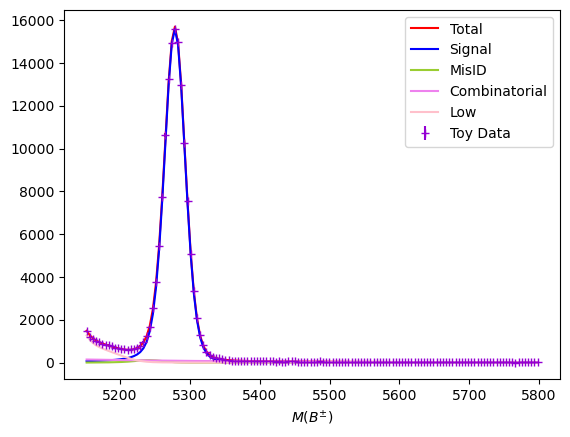

In [ ]:
fig, ax = plt.subplots()
plotOn(data=Bu_M, var=[], decay='b2dpi_DD',  ax=ax, nbins=144)

# Simultaneous fit on DK and DPi

In [ ]:
def nll_extended_dk_dd(par):
    decay = 'b2dk_DD'
    x= Bu_M[decay]
    nsig = par[0]
    nmisid = par[3]/(varDict_init['pideff_DPi_KsPiPi_p_to_p_DD']) * varDict_init['pideff_DPi_KsPiPi_p_to_k_DD']
    ncomb = par[1]
    nlow = par[2]
    frac_low_misID = varDict_init['cp_range_n_low_misID_DK_KsPiPi_DD']/varDict_init['cp_range_n_low_DPi_KsPiPi_DD']
    nlow_misID = par[5]*frac_low_misID
    nlow_Bs2DKPi = varDict_init['cp_range_n_low_Bs2DKPi_DK_KsPiPi_DD']

    pdf = lambda x: pdfs_data[decay]['sig'](x)*nsig
    pdf2 = lambda x: pdfs_data[decay]['misid'](x)*nmisid
    pdf3 = lambda x: pdfs_data[decay]['comb'](x)*ncomb
    pdf4 = lambda x: pdfs_data[decay]['low'](x)*nlow
    pdf5 = lambda x: pdfs_data[decay]['low_misID'](x)*nlow_misID
    pdf6 = lambda x: pdfs_data[decay]['low_Bs2DKPi'](x)*nlow_Bs2DKPi
    ntotal = (nsig + nmisid + ncomb + nlow + nlow_misID + nlow_Bs2DKPi)

    npdf = pdf(x) + pdf2(x) + pdf3(x) + pdf4(x) + pdf5(x) + pdf6(x)


    nll =  tf.reduce_sum(- 2 *np.log(npdf)) + 2* ntotal
    
    return nll

def nll_extended_dpi_dd(par):
    decay = 'b2dpi_DD'
    x= Bu_M[decay]
    nsig = par[3]
    nmisid = par[0]/(varDict_init['pideff_DK_KsPiPi_k_to_k_DD']) * varDict_init['pideff_DK_KsPiPi_k_to_p_DD']
    ncomb = par[4]
    nlow = par[5]

    pdf = lambda x: pdfs_data[decay]['sig'](x)*nsig
    pdf2 = lambda x: pdfs_data[decay]['misid'](x)*nmisid
    pdf3 = lambda x: pdfs_data[decay]['comb'](x)*ncomb
    pdf4 = lambda x: pdfs_data[decay]['low'](x)*nlow

    ntotal = (nsig + nmisid + ncomb + nlow )

    npdf = pdf(x) + pdf2(x) + pdf3(x) + pdf4(x)

    nll = tf.reduce_sum(- 2 * np.log(npdf)) + 2 * ntotal
    
    return nll   

def nll_dd(x):
    print(nll_extended_dk_dd(x) + nll_extended_dpi_dd(x))
    return nll_extended_dk_dd(x) + nll_extended_dpi_dd(x)

In [ ]:
x_ini = [varDict_init['cp_range_n_sig_DK_KsPiPi_DD'], varDict_init['cp_range_n_comb_DK_KsPiPi_DD'], varDict_init['cp_range_n_low_DK_KsPiPi_DD'],  varDict_init['cp_range_n_sig_DPi_KsPiPi_DD'], varDict_init['cp_range_n_comb_DPi_KsPiPi_DD'], varDict_init['cp_range_n_low_DPi_KsPiPi_DD']]

n_data = {'b2dk_DD': len(Bu_M['b2dk_DD']), 'b2dpi_DD': len(Bu_M['b2dpi_DD'])}
bounds = [(-n_data['b2dk_DD'], 1.2*n_data['b2dk_DD']), (-n_data['b2dk_DD'], 1.2*n_data['b2dk_DD']), (-n_data['b2dk_DD'], 1.2*n_data['b2dk_DD']), (-n_data['b2dpi_DD'], 1.2*n_data['b2dpi_DD']), (-n_data['b2dpi_DD'], 1.2*n_data['b2dpi_DD']), (-n_data['b2dpi_DD'], 1.2*n_data['b2dpi_DD'])]
model = minimize(nll_dd, x_ini, method="L-BFGS-B", bounds=bounds)


/software/pc24403/tfpcbpggsz/example/massshape.py:42: RuntimeWarning: overflow encountered in exp
  firstG1 = ((2*(a_new-2*B_NEW+(m-shift))*sigma)/np.exp((a_new-(m-shift))*(a_new-(m-shift))/(2*sigma*sigma)) - (2*(b_new-2*B_NEW+(m-shift))*sigma)/np.exp((b_new-(m-shift))*(b_new-(m-shift))/(2*sigma*sigma))+ np.sqrt(2*np.pi)*((B_NEW-(m-shift))*(B_NEW-(m-shift)) + sigma*sigma)*erf((-a_new+(m-shift))/(np.sqrt(2)*sigma))  - np.sqrt(2*np.pi)*((B_NEW-(m-shift))*(B_NEW-(m-shift)) + sigma*sigma) * erf((-b_new+(m-shift))/(np.sqrt(2)*sigma)))/(2*np.sqrt(2*np.pi))
/software/pc24403/tfpcbpggsz/example/massshape.py:43: RuntimeWarning: overflow encountered in exp
  secondG1 = (((2*sigma*(a_new*a_new + B_NEW*B_NEW + a_new*(m-shift) + (m-shift)*(m-shift) - 2*B_NEW*(a_new+(m-shift)) + 2*(sigma*sigma)))/np.exp((a_new-(m-shift))*(a_new-(m-shift))/(2*(sigma*sigma))) - (2*sigma*(b_new*b_new + B_NEW*B_NEW + b_new*(m-shift) + (m-shift)*(m-shift) - 2*B_NEW*(b_new + (m-shift)) + 2*(sigma*sigma)))/np.exp((b_new - 

tf.Tensor(-2097166.207168456, shape=(), dtype=float64)
tf.Tensor(-2097166.2071684585, shape=(), dtype=float64)
tf.Tensor(-2097166.207168456, shape=(), dtype=float64)
tf.Tensor(-2097166.2071684552, shape=(), dtype=float64)
tf.Tensor(-2097166.207168456, shape=(), dtype=float64)
tf.Tensor(-2097166.207168456, shape=(), dtype=float64)
tf.Tensor(-2097166.207168456, shape=(), dtype=float64)
tf.Tensor(-2097166.2676579487, shape=(), dtype=float64)
tf.Tensor(-2097166.2676579505, shape=(), dtype=float64)
tf.Tensor(-2097166.2676579487, shape=(), dtype=float64)
tf.Tensor(-2097166.2676579477, shape=(), dtype=float64)
tf.Tensor(-2097166.2676579487, shape=(), dtype=float64)
tf.Tensor(-2097166.2676579487, shape=(), dtype=float64)
tf.Tensor(-2097166.267657949, shape=(), dtype=float64)
tf.Tensor(-2097166.7882419727, shape=(), dtype=float64)
tf.Tensor(-2097166.7882419745, shape=(), dtype=float64)
tf.Tensor(-2097166.7882419727, shape=(), dtype=float64)
tf.Tensor(-2097166.7882419717, shape=(), dtype=float64

In [ ]:
minimized_dk_dd_nsig = model.x[0]
minimized_dk_dd_nmisid = model.x[3]/(varDict_init['pideff_DPi_KsPiPi_p_to_p_DD']) * varDict_init['pideff_DPi_KsPiPi_p_to_k_DD']
minimized_dk_dd_ncomb = model.x[1]
minimized_dk_dd_nlow = model.x[2]
dk_dd_frac_low_misID = varDict_init['cp_range_n_low_misID_DK_KsPiPi_DD']/varDict_init['cp_range_n_low_DPi_KsPiPi_DD']
minimized_dk_dd_nlow_misID = model.x[5]*dk_dd_frac_low_misID
minimized_dk_dd_nlow_Bs2DKPi = varDict_init['cp_range_n_low_Bs2DKPi_DK_KsPiPi_DD']
minimized_dpi_dd_nsig = model.x[3]
minimized_dpi_dd_nmisid = model.x[0]/(varDict_init['pideff_DK_KsPiPi_k_to_k_DD']) * varDict_init['pideff_DK_KsPiPi_k_to_p_DD']
minimized_dpi_dd_ncomb = model.x[4]
minimized_dpi_dd_nlow = model.x[5]

n_obs = [minimized_dk_dd_nsig, minimized_dk_dd_nmisid, minimized_dk_dd_ncomb, minimized_dk_dd_nlow, minimized_dk_dd_nlow_misID, minimized_dk_dd_nlow_Bs2DKPi, minimized_dpi_dd_nsig, minimized_dpi_dd_nmisid, minimized_dpi_dd_ncomb, minimized_dpi_dd_nlow]


In [ ]:
x_exp = [varDict['n_sig_DK_KsPiPi_DD'], varDict['n_misid_DK_KsPiPi_DD'], varDict['n_comb_DK_KsPiPi_DD'], varDict['n_low_DK_KsPiPi_DD'], varDict['n_low_misID_DK_KsPiPi_DD'], varDict['n_low_Bs2DKPi_DK_KsPiPi_DD'], varDict['n_sig_DPi_KsPiPi_DD'], varDict['n_misid_DPi_KsPiPi_DD'], varDict['n_comb_DPi_KsPiPi_DD'], varDict['n_low_DPi_KsPiPi_DD']]

In [ ]:
#Difference
print('nsig: %.2f'%(n_obs[0] - x_exp[0]))
print('nmisid: %.2f'%(n_obs[1] - x_exp[1]))
print('ncomb: %.2f'%(n_obs[2] - x_exp[2]))
print('nlow: %.2f'%(n_obs[3] - x_exp[3]))
print('nlow_misID: %.2f'%(n_obs[4] - x_exp[4]))
print('nlow_Bs2DKPi: %.2f'%(n_obs[5] - x_exp[5]))
print('nsig: %.2f'%(n_obs[6] - x_exp[6]))
print('nmisid: %.2f'%(n_obs[7] - x_exp[7]))
print('ncomb: %.2f'%(n_obs[8] - x_exp[8]))
print('nlow: %.2f'%(n_obs[9] - x_exp[9]))

nsig: 76.27
nmisid: -7.94
ncomb: -78.58
nlow: -156.35
nlow_misID: 43.22
nlow_Bs2DKPi: 0.08
nsig: -272.75
nmisid: 11.50
ncomb: -144.56
nlow: 387.46
